In [3]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

c:\Users\lukas\miniforge3\envs\pypsa-earth\lib\site-packages\pypsa\networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [4]:
path = Path.cwd().parent / 'data' / 'base'

In [ ]:
dr = pd.date_range('2022-01-01', '2025-01-01', freq='d').strftime('%Y-%m-%d')


pns = []
prices = []
nemos = []

for day in tqdm(dr):

    try:
        gen = pd.read_csv(path / day / 'physical_notifications.csv', index_col=0, parse_dates=True)
        price = pd.read_csv(path / day / 'day_ahead_prices.csv', index_col=0, parse_dates=True)
        nemo = pd.read_csv(path / day / 'nemo_powerflow.csv', index_col=0, parse_dates=True)

        pns.append(gen)
        prices.append(price)
        nemos.append(nemo)

    except FileNotFoundError:
        continue

100%|██████████| 1097/1097 [01:34<00:00, 11.67it/s]


In [ ]:
price_df = pd.concat(prices)

In [7]:
pns_df = pd.concat(pns)# .clip(lower=0).sum(axis=1)

In [8]:
nemo_df = pd.concat(nemos)

In [9]:
n = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex.nc'
)

c:\Users\lukas\miniforge3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\lukas\miniforge3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\lukas\miniforge3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

In [10]:
import yaml

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    data = yaml.safe_load(f)

interconnection_mapper = data['interconnection_mapper']

real_int_flow = pd.DataFrame(index=pns_df.index)

for name, bmu_names in interconnection_mapper.items():
    if name == 'Nemo':
        real_int_flow[name] = nemo_df.iloc[:,0]

    else:
        real_int_flow[name] = (
            pns_df[pns_df.columns[pns_df.columns.str.contains('|'.join(bmu_names))]]
            .sum(axis=1)
        )

export = real_int_flow.clip(upper=0).sum(axis=1).mul(-1)

In [11]:
storages = n.storage_units.index.intersection(pns_df.columns)
charging = pns_df[storages].clip(upper=0).sum(axis=1).mul(-1)

assert (charging >= 0).all(), 'Charging should be negative.'

net_load = pns_df.clip(lower=0).sum(axis=1) - export - charging

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

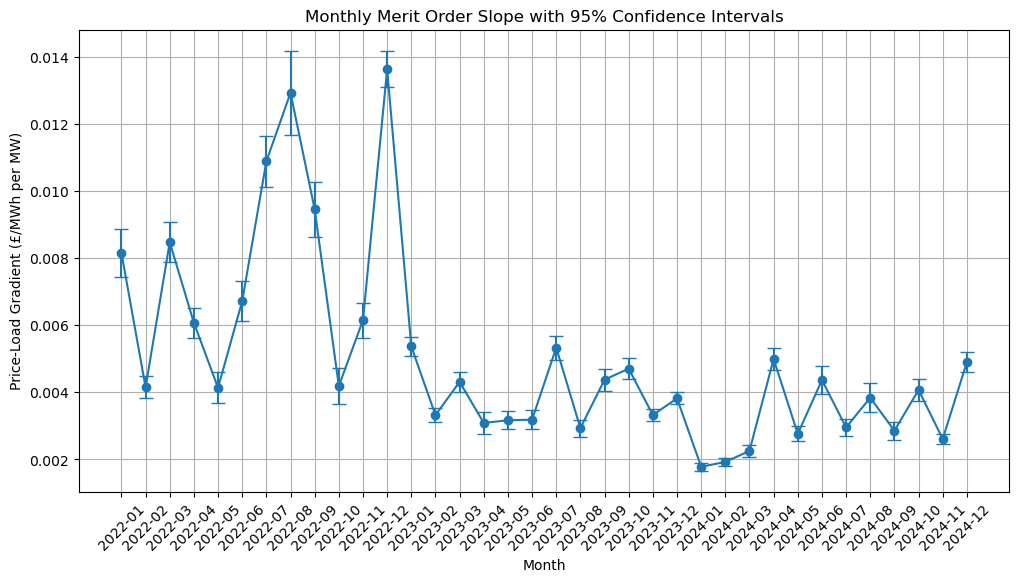

In [22]:
ms = pd.date_range('2022-01-01', '2025-01-01', freq='ME').strftime('%Y-%m')
from scipy import stats
import matplotlib.pyplot as plt

gradients = []
errors = []

for m in ms:
    ssload = net_load.loc[m]
    ssprice = price_df.loc[m]
    
    # Ensure arrays have matching dimensions by converting to numpy arrays
    ssload = ssload.values.reshape(-1)
    ssprice = ssprice.values.reshape(-1)
    
    # Calculate linear regression with confidence intervals
    
    # Filter out NaN values before regression
    mask = ~np.isnan(ssload) & ~np.isnan(ssprice)
    ssload_clean = ssload[mask]
    ssprice_clean = ssprice[mask]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ssload_clean, ssprice_clean)

    gradients.append(slope)
    errors.append(std_err * 1.96)  # 95% confidence interval

# Plot results
plt.figure(figsize=(12, 6))
plt.errorbar(ms, gradients, yerr=errors, fmt='o-', capsize=5)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Price-Load Gradient (£/MWh per MW)')
plt.title('Monthly Merit Order Slope with 95% Confidence Intervals')
plt.grid(True)


In [23]:
pd.DataFrame(
    {
        'gradient': gradients,
        'error': errors
    },
    index=ms
)

,gradient,error
2022-01,0.008162,0.000726
2022-02,0.004150,0.000326
2022-03,0.008481,0.000593
2022-04,0.006073,0.000441
2022-05,0.004137,0.000461
2022-06,0.006720,0.000594
2022-07,0.010891,0.000767
2022-08,0.012938,0.001255
2022-09,0.009462,0.000821
2022-10,0.004189,0.000527


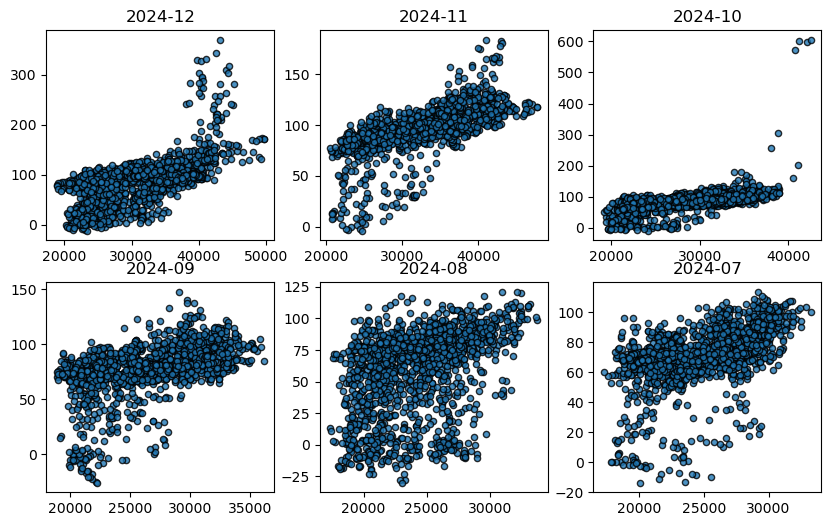

In [61]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

scatter_kwargs = {
    's': 20,
    'edgecolor': 'k',
    'alpha': 0.8,
}

for c, ax in zip(ms[::-1], axs.flatten()):

    ax.scatter(net_load.loc[c], price_df.loc[c], **scatter_kwargs)
    ax.set_title(c)

plt.show()